In [19]:
"""
Reference: https://raphaelvallat.com/bandpower.html
"""

from scipy import signal
from scipy.integrate import simps

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_utils import (
    get_sorted_block_to_data_by_marker,
    load_data_from_dir,
)
from feature_extraction import (
    Feature,
    EEG_BANDS,
)

In [24]:
# All constants
DIR_NAME = "../CleandDataV1/2017"
BLOCK_NAME = 'audio_hvla'
MARKER = 'EEG'
CHANNEL = 50
EPOCH = 0
BAND = Feature.DELTA

In [3]:
all_data = load_data_from_dir(DIR_NAME)

Loading ../CleandDataV1/2017 data...


In [25]:
# retrieve the data from marker's channel 1
data = all_data[BLOCK_NAME].get_all_data()[MARKER][CHANNEL]
# (num_data_points, num_epochs) => (num_epochs, num_data_points)
data = np.swapaxes(data,0,1)  
# get first epoch
data = data[EPOCH]

channels = all_data[BLOCK_NAME].get_chanlocs(MARKER)

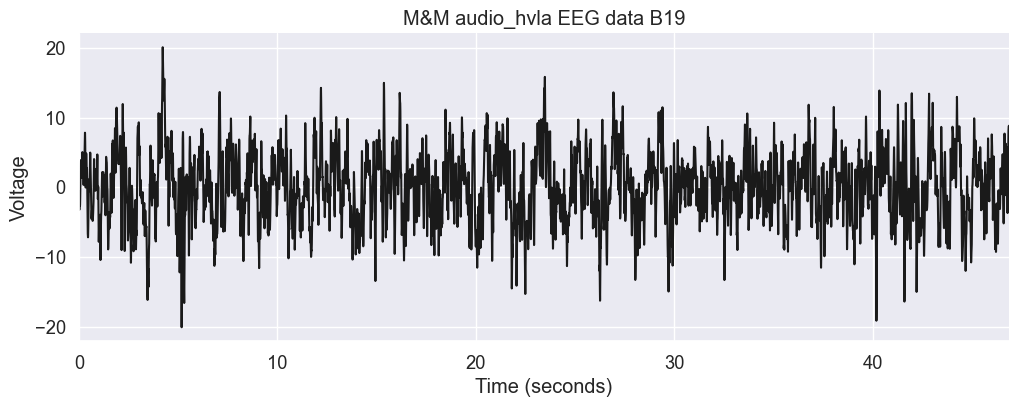

In [26]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 512.
time = all_data[BLOCK_NAME].get_times(MARKER) / sf
 
# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title(f'M&M {BLOCK_NAME} EEG data {channels[CHANNEL]}')
sns.despine()

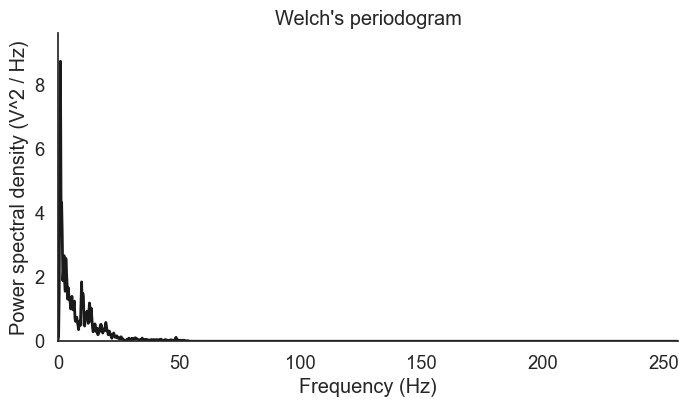

In [27]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

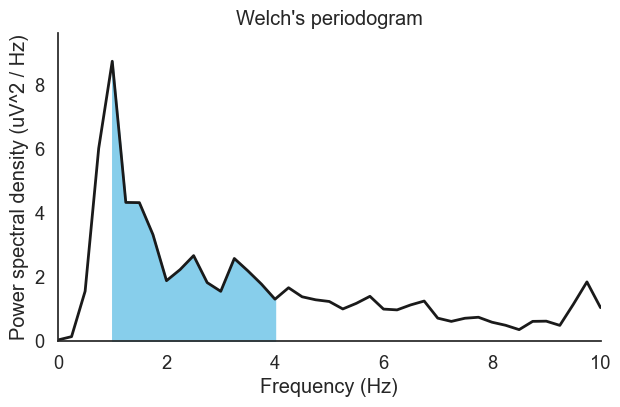

In [28]:
# Define lower and upper limits
low, high = EEG_BANDS[BAND]

# Find intersecting values in frequency vector
idx_psd = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_psd, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [32]:
# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_psd], dx=freq_res)
print(f'Absolute {BAND.name} power: %.3f uV^2' % delta_power)

Absolute DELTA power: 8.314 uV^2
